## Imports

In [1]:
from datasets import load_dataset, Dataset
from tokenizers import Tokenizer, AddedToken, Regex
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Split
from tokenizers.normalizers import Lowercase
from transformers import PreTrainedTokenizerFast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
from tqdm import tqdm

In [3]:
DATASET_REPO_ID = "isek-ai/danbooru-tags-2024"
DATASET_NAME = "202402-at20240326"
DATASET_SPLIT = "train"

## Load dataset

In [4]:
def prepare_dataset():
    ds = load_dataset(DATASET_REPO_ID, name=DATASET_NAME, split=DATASET_SPLIT)
    print(ds)
    return ds


ds = prepare_dataset()

Dataset({
    features: ['id', 'copyright', 'character', 'artist', 'general', 'meta', 'rating', 'score', 'created_at'],
    num_rows: 7124975
})


In [5]:
def load_from_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def save_to_json(data, path: str):
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

## Investigate the dataset

In [6]:
def get_count_map(column_name: str):
    count_map = {}

    for text in tqdm(ds[column_name]):
        if text is None:
            continue
        for tag in text.split(", "):
            if tag not in count_map:
                count_map[tag] = 1
            count_map[tag] += 1

    count_map = {
        k: v for k, v in sorted(count_map.items(), key=lambda x: x[1], reverse=True)
    }
    return count_map


general_tags_count_map = get_count_map("general")
save_to_json(general_tags_count_map, "../data/general_tags_count_map.json")
general_tags_count_map

100%|██████████| 7124975/7124975 [00:30<00:00, 233203.03it/s]


{'1girl': 5071347,
 'solo': 4233465,
 'long hair': 3626142,
 'breasts': 2868312,
 'looking at viewer': 2693349,
 'blush': 2479142,
 'smile': 2355676,
 'open mouth': 1938878,
 'short hair': 1893313,
 'blue eyes': 1482719,
 'simple background': 1417790,
 'shirt': 1381800,
 'large breasts': 1321698,
 'skirt': 1321065,
 'blonde hair': 1301381,
 'multiple girls': 1296493,
 'brown hair': 1258113,
 'black hair': 1219721,
 'long sleeves': 1198509,
 'hair ornament': 1168485,
 'white background': 1161490,
 '1boy': 1113347,
 'gloves': 1109069,
 'red eyes': 1075554,
 'dress': 1044181,
 'hat': 1026066,
 'thighhighs': 1025587,
 'holding': 1024716,
 'bow': 980035,
 'navel': 968152,
 'animal ears': 946708,
 'ribbon': 931157,
 'hair between eyes': 922360,
 'closed mouth': 878554,
 '2girls': 853719,
 'cleavage': 844904,
 'jewelry': 828390,
 'bare shoulders': 812866,
 'very long hair': 780557,
 'sitting': 779450,
 'medium breasts': 765635,
 'twintails': 765380,
 'brown eyes': 742110,
 'standing': 734702,

In [8]:
# cached data
general_tags_count_map = load_from_json("../data/general_tags_count_map.json")

### plot the distribution of counts

#### general

In [9]:
# plot the distribution of counts
general_tags_counts = [count for name, count in general_tags_count_map.items()]

In [10]:
general_tags_counts[0]

5071347

In [11]:
len(general_tags_counts)

74574

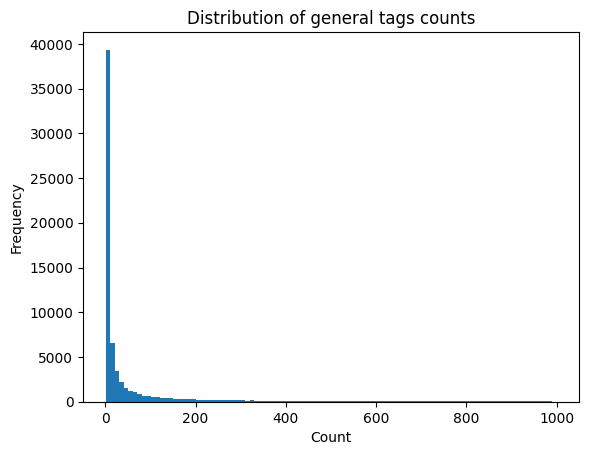

In [12]:
plt.hist(general_tags_counts, bins=100, range=(1, 1000))
# plt.yscale("log")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.title("Distribution of general tags counts")
plt.show()

In [14]:
popular_general_tags = [
    name for name, count in general_tags_count_map.items() if count > 1000
]
save_to_json(popular_general_tags, "../data/popular_general_tags.json")
len(popular_general_tags)

6789

### show distribution of tags score

In [107]:
# get scores by rating
post_scores_rating_general = ds.filter(lambda x: x["rating"] == "g", batched=False)[
    "score"
]
post_scores_rating_sensitive = ds.filter(lambda x: x["rating"] == "s", batched=False)[
    "score"
]
post_scores_rating_questionable = ds.filter(
    lambda x: x["rating"] == "q", batched=False
)["score"]
post_scores_rating_explicit = ds.filter(lambda x: x["rating"] == "e", batched=False)[
    "score"
]

Filter:   0%|          | 0/7124975 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7124975 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7124975 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7124975 [00:00<?, ? examples/s]

In [111]:
print(len(post_scores_rating_explicit))
print(len(post_scores_rating_questionable))
print(len(post_scores_rating_sensitive))
print(len(post_scores_rating_general))

687358
882858
3951666
1603093


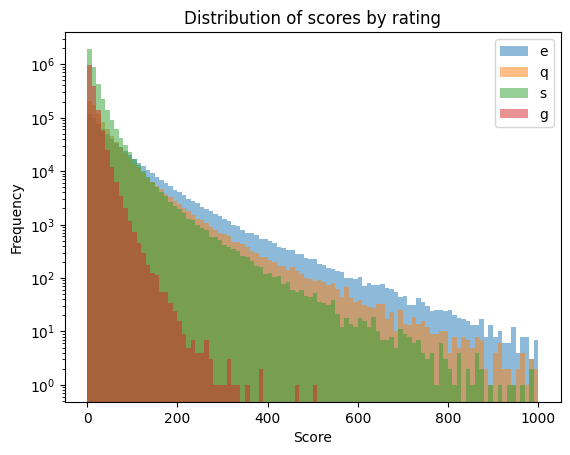

In [110]:
# plot all scores
plt.hist(post_scores_rating_explicit, bins=100, range=(0, 1000), alpha=0.5, label="e")
plt.hist(
    post_scores_rating_questionable, bins=100, range=(0, 1000), alpha=0.5, label="q"
)
plt.hist(post_scores_rating_sensitive, bins=100, range=(0, 1000), alpha=0.5, label="s")
plt.hist(post_scores_rating_general, bins=100, range=(0, 1000), alpha=0.5, label="g")
plt.legend()
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of scores by rating")
plt.show()

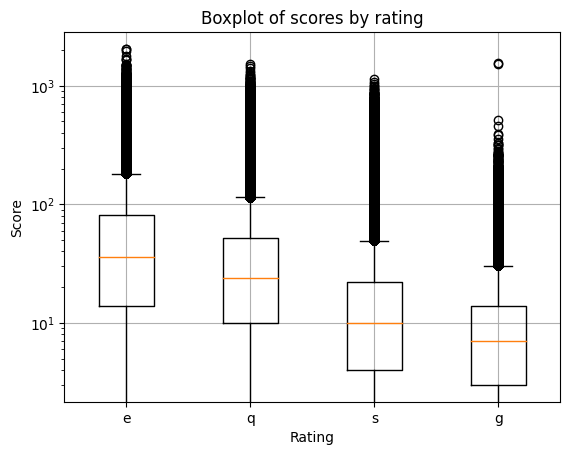

In [126]:
# boxplot
plt.boxplot(
    [
        post_scores_rating_explicit,
        post_scores_rating_questionable,
        post_scores_rating_sensitive,
        post_scores_rating_general,
    ],
    labels=[
        "e",
        "q",
        "s",
        "g",
    ],
)
plt.yscale("log")
plt.xlabel("Rating")
plt.ylabel("Score")
plt.title("Boxplot of scores by rating")
plt.grid()
plt.show()

In [117]:
# sort by score
post_scores_rating_explicit.sort()
post_scores_rating_questionable.sort()
post_scores_rating_sensitive.sort()
post_scores_rating_general.sort()

In [148]:
# group by ratio and get the boundary score of each group
# ~ 10%, ~ 25%, ~75%, ~90%


def get_boundary_scores(scores):
    return [scores[int(len(scores) * ratio)] for ratio in [0.1, 0.25, 0.75, 0.9]]


boundary_scores_explicit = get_boundary_scores(post_scores_rating_explicit)
boundary_scores_questionable = get_boundary_scores(post_scores_rating_questionable)
boundary_scores_sensitive = get_boundary_scores(post_scores_rating_sensitive)
boundary_scores_general = get_boundary_scores(post_scores_rating_general)

quality_score_map = {
    "general": boundary_scores_general,
    "sensitive": boundary_scores_sensitive,
    "questionable": boundary_scores_questionable,
    "explicit": boundary_scores_explicit,
}
save_to_json(quality_score_map, "./tmp/quality_score_map.json")
quality_score_map

{'general': [1, 3, 14, 24],
 'sensitive': [1, 4, 22, 44],
 'questionable': [4, 10, 52, 99],
 'explicit': [5, 14, 81, 151]}

In [150]:
def show_each_group_counts(scores, boundary_scores):
    counts = [0] * (len(boundary_scores) + 1)
    for score in scores:
        for i, boundary_score in enumerate(boundary_scores):
            if score <= boundary_score:
                counts[i] += 1
                break
        else:
            counts[-1] += 1
    return counts

In [153]:
print(show_each_group_counts(post_scores_rating_general, boundary_scores_general))

[188322, 239116, 784758, 230657, 160240]


In [154]:
print(show_each_group_counts(post_scores_rating_sensitive, boundary_scores_sensitive))

[429991, 683759, 1880060, 565512, 392344]


In [155]:
print(
    show_each_group_counts(
        post_scores_rating_questionable, boundary_scores_questionable
    )
)

[102755, 130558, 430707, 131044, 87794]


In [157]:
print(show_each_group_counts(post_scores_rating_explicit, boundary_scores_explicit))

[76615, 100853, 339210, 102541, 68139]


## Gather tokens

### Prepare special tokens

In [15]:
BOS_TOKEN = "<|bos|>"
EOS_TOKEN = "<|eos|>"
PAD_TOKEN = "<|pad|>"
UNK_TOKEN = "<|unk|>"
SEP_TOKEN = "<|sep|>"
MASK_TOKEN = "<|mask|>"

# group
RATING_START = "<rating>"
RATING_END = "</rating>"
GENERAL_START = "<general>"
GENERAL_END = "</general>"
CHARACTER_START = "<character>"
CHARACTER_END = "</character>"
COPYRIGHT_START = "<copyright>"
COPYRIGHT_END = "</copyright>"

# rating
RATING_SFW = "rating:sfw"
RATING_NSFW = "rating:nsfw"
RATING_GENERAL = "rating:general"
RATING_SENSITIVE = "rating:sensitive"
RATING_QUESTIONABLE = "rating:questionable"
RATING_EXPLICIT = "rating:explicit"

# quality
QUALITY_BEST = "<|best_quality|>"
QUALITY_HIGH = "<|high_quality|>"
QUALITY_NORMAL = "<|normal_quality|>"
QUALITY_LOW = "<|low_quality|>"
QUALITY_WORST = "<|worst_quality|>"

# total tags length
LENGTH_VERY_SHORT = "<|very_short|>"
LENGTH_SHORT = "<|short|>"
LENGTH_MEDIUM = "<|medium|>"
LENGTH_LONG = "<|long|>"
LENGTH_VERY_LONG = "<|very_long|>"

# aspect ratio
ASPECT_RATIO_ULTRA_WIDE = "<|ultra_wide|>"
ASPECT_RATIO_WIDE = "<|wide|>"
ASPECT_RATIO_SQUARE = "<|square|>"
ASPECT_RATIO_TALL = "<|tall|>"
ASPECT_RATIO_ULTRA_TALL = "<|ultra_tall|>"

# for SFT
INPUT_START = "<|input_start|>"
INPUT_END = "<|input_end|>"

# flags
FLAG_KEEP_IDENTITY = "<|keep_identity|>"

In [16]:
RESERVED_TOKENS = [f"<|reserved_{i}|>" for i in range(32)]

In [17]:
SPECIAL_TOKENS = [
    BOS_TOKEN,
    EOS_TOKEN,
    PAD_TOKEN,
    UNK_TOKEN,
    SEP_TOKEN,
    MASK_TOKEN,
    # not used in debertav2 tokenizer
    # #
    # RATING_START,
    # RATING_END,
    # GENERAL_START,
    # GENERAL_END,
    # CHARACTER_START,
    # CHARACTER_END,
    # #
    # RATING_SFW,
    # RATING_NSFW,
    # RATING_GENERAL,
    # RATING_SENSITIVE,
    # RATING_QUESTIONABLE,
    # RATING_EXPLICIT,
    # #
    # QUALITY_BEST,
    # QUALITY_HIGH,
    # QUALITY_NORMAL,
    # QUALITY_LOW,
    # QUALITY_WORST,
    # #
    # LENGTH_VERY_SHORT,
    # LENGTH_SHORT,
    # LENGTH_MEDIUM,
    # LENGTH_MEDIUM,
    # LENGTH_LONG,
    # LENGTH_VERY_LONG,
    # #
    # ASPECT_RATIO_ULTRA_WIDE,
    # ASPECT_RATIO_WIDE,
    # ASPECT_RATIO_SQUARE,
    # ASPECT_RATIO_TALL,
    # ASPECT_RATIO_ULTRA_TALL,
    # #
    # INPUT_START,
    # INPUT_END,
    # #
    # FLAG_KEEP_IDENTITY,
    # #
    *RESERVED_TOKENS,
]
len(SPECIAL_TOKENS)

38

### Prepare general/character/copyright tags

In [18]:
GENERAL_TAG_TOKENS = popular_general_tags
# CHARACTER_TAG_TOKENS = popular_character_tags
# COPYRIGHT_TAG_TOKENS = popular_copyright_tags

### All

In [19]:
ALL_TOKENS = [
    *SPECIAL_TOKENS,
    *GENERAL_TAG_TOKENS,
    # *CHARACTER_TAG_TOKENS,
    # *COPYRIGHT_TAG_TOKENS,
]

## Create a tokenizer!

In [20]:
tokenizer = Tokenizer(
    # 頭から順番に番号をつける
    WordLevel(vocab={tag: i for i, tag in enumerate(ALL_TOKENS)}, unk_token=UNK_TOKEN)
)

In [21]:
tokenizer.normalizer = Lowercase()

In [22]:
tokenizer.pre_tokenizer = Split(
    pattern=Regex(r",(?:\s)*"), behavior="removed", invert=False
)

In [23]:
# register special tokens
tokenizer.add_special_tokens(
    [
        AddedToken(
            content=token,
        )
        for token in SPECIAL_TOKENS
    ]
)

38

In [24]:
# padding
tokenizer.enable_padding(pad_token=PAD_TOKEN)

In [25]:
tokenizer.get_vocab_size()

6827

#### Test tokenizer

In [26]:
tokenizer.encode(
    "1girl, 2girls, aaa, long hair, very long hair, honkai: star rail, arknights, hogeeeeeeeee",
).tokens

['1girl',
 '2girls',
 '<|unk|>',
 'long hair',
 'very long hair',
 '<|unk|>',
 '<|unk|>',
 '<|unk|>']

In [ ]:
# save if you want
# tokenizer.save("./tmp/tokenizer.json")

#### Transformers tokenizer format

In [27]:
pretrained_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

pretrained_tokenizer.bos_token = BOS_TOKEN
pretrained_tokenizer.eos_token = EOS_TOKEN
pretrained_tokenizer.pad_token = PAD_TOKEN
pretrained_tokenizer.unk_token = UNK_TOKEN
pretrained_tokenizer.mask_token = MASK_TOKEN

In [28]:
pretrained_tokenizer.encode_plus("1girl, cat ears, blue hair, swept bangs")

{'input_ids': [38, 188, 85, 379], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [29]:
pretrained_tokenizer.push_to_hub("p1atdev/dart-popular-general-tags-tokenizer")

CommitInfo(commit_url='https://huggingface.co/p1atdev/dart-popular-general-tags-tokenizer/commit/ad0c3e90ccdaae97044453a54337f06fb5d84df8', commit_message='Upload tokenizer', commit_description='', oid='ad0c3e90ccdaae97044453a54337f06fb5d84df8', pr_url=None, pr_revision=None, pr_num=None)